In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from scipy.stats import zscore

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3830)])
    except RuntimeError as e:
        print(e)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-06-05 15:08:47.392223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 15:08:47.393159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 15:08:47.527909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 15:08:47.758998: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 15:08:56.506607: I external/

In [29]:
def show(df, title, dateIndex=False):
    for column in df.columns:
        if column != 'Date':
            plt.figure(figsize=(20, 2))
            if dateIndex:
                plt.plot(df[column])
            else:
                plt.plot(df['Date'], df[column])
            plt.title(title + ":" + column)
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.show()

def normalize(df):
    result = df.copy()
    for column in df.columns:
        if df[column].dtype == np.number:
            min_col = df[column].min()
            max_col = df[column].max()
            result[column] = (df[column] - min_col) / (max_col - min_col)
    return result
            
def primitiveRemoveRepeatingValues(df, columnToCheck, nThreshold = 40):
    count = 1
    previous_value = df[columnToCheck].iloc(0)
    for index, value in df[columnToCheck][1:].items():
        if value == previous_value:
            count += 1
        else:
            if count >= nThreshold:
                df.loc[index - count : index, columnToCheck] = np.nan
            count = 1
        previous_value = value
        
def fillMissing(df):
    df['Depth_to_Groundwater_P24'] = df['Depth_to_Groundwater_P24'].interpolate()
    df['Depth_to_Groundwater_P25'] = df['Depth_to_Groundwater_P25'].interpolate()

    imputer = KNNImputer(n_neighbors=5)
    df_nodate = df.copy().drop(columns=["Date"])
    df_nodate.iloc[:-40 * 4] = imputer.fit_transform(df_nodate[:-40 * 4])
        
    df_nodate.iloc[-40 * 4:-20 * 4] = imputer.transform(df_nodate[-40 * 4:-20 * 4])

    df_nodate.iloc[-20 * 4:] = imputer.transform(df_nodate[-20 * 4:])

    df_nodate['Date'] = df["Date"]
    return df_nodate

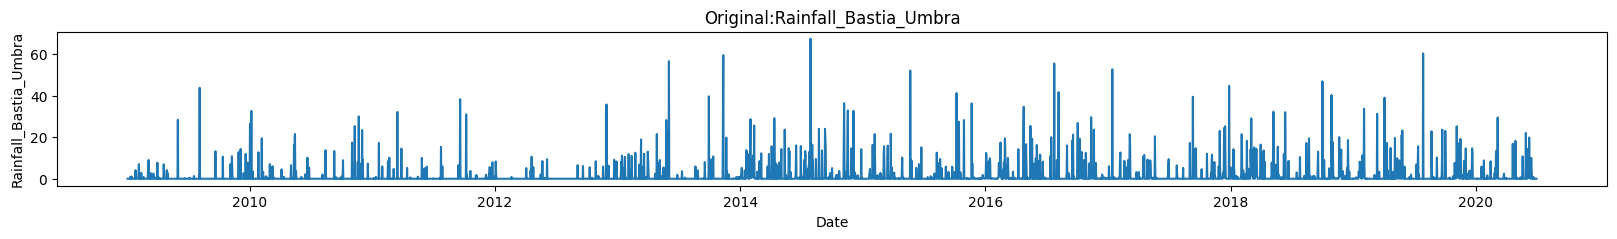

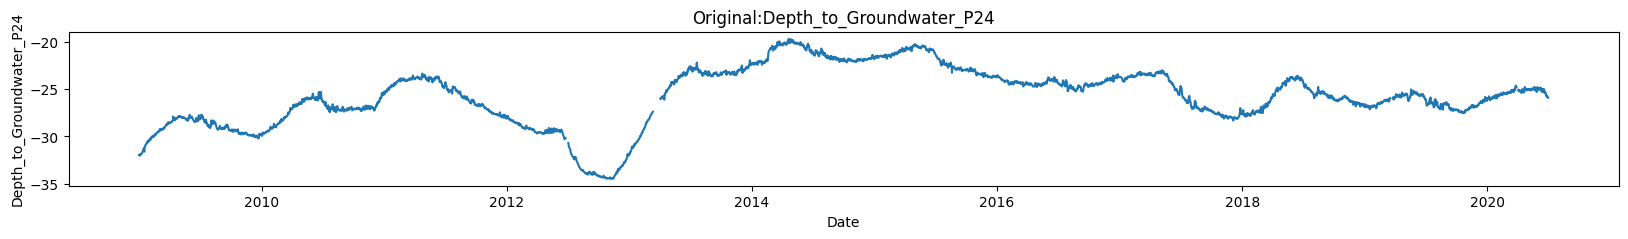

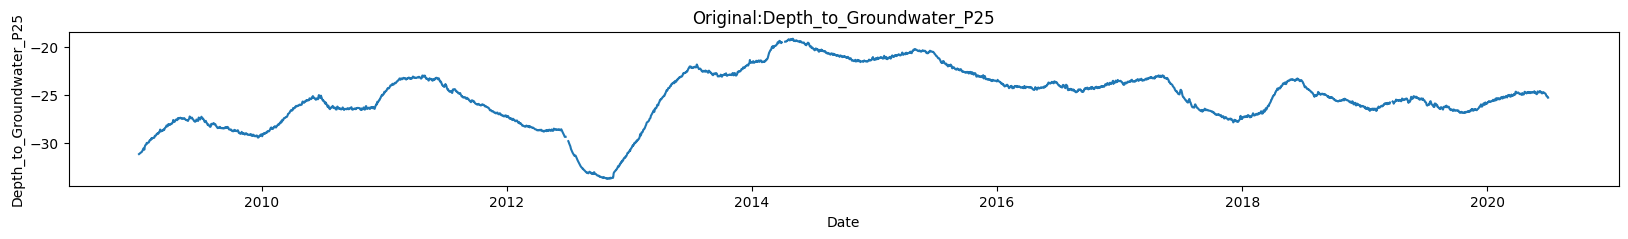

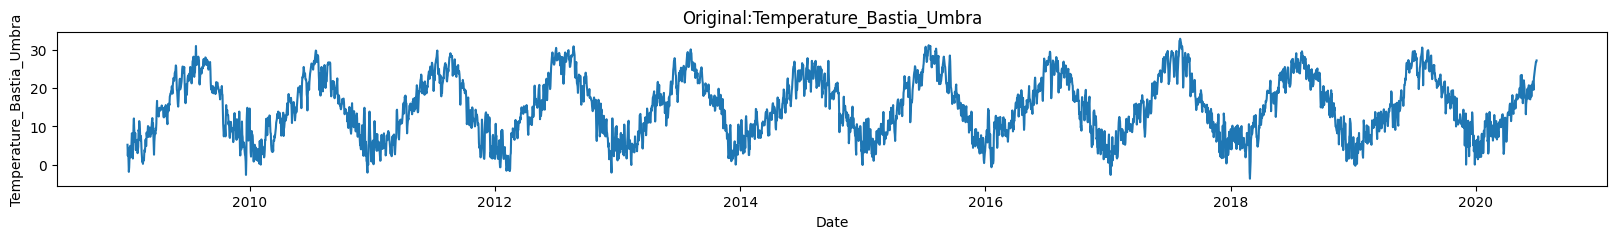

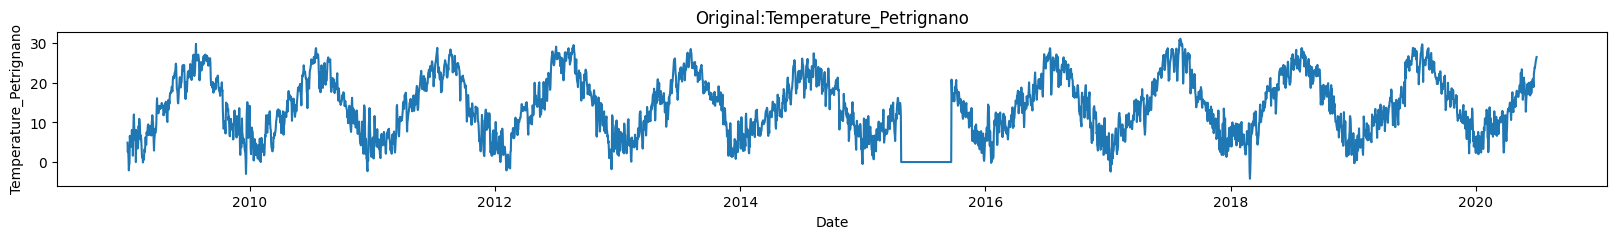

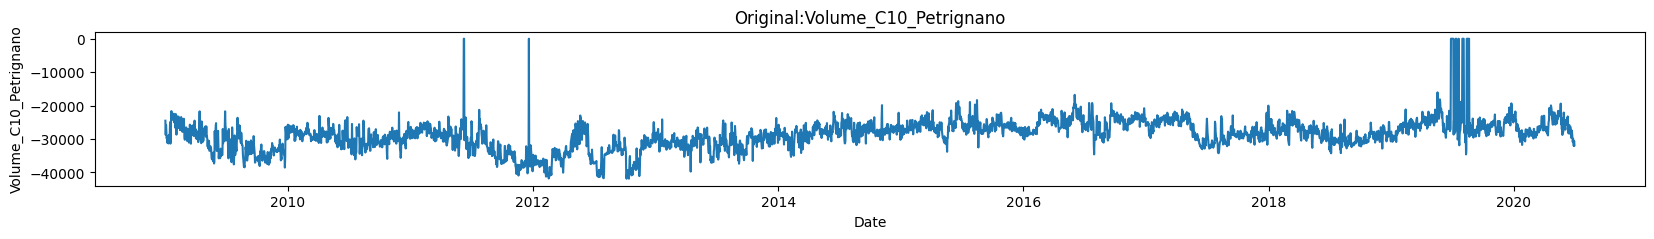

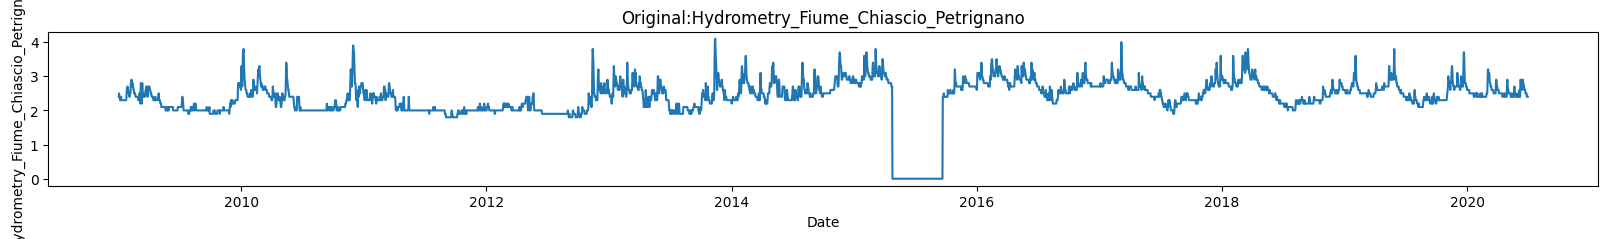

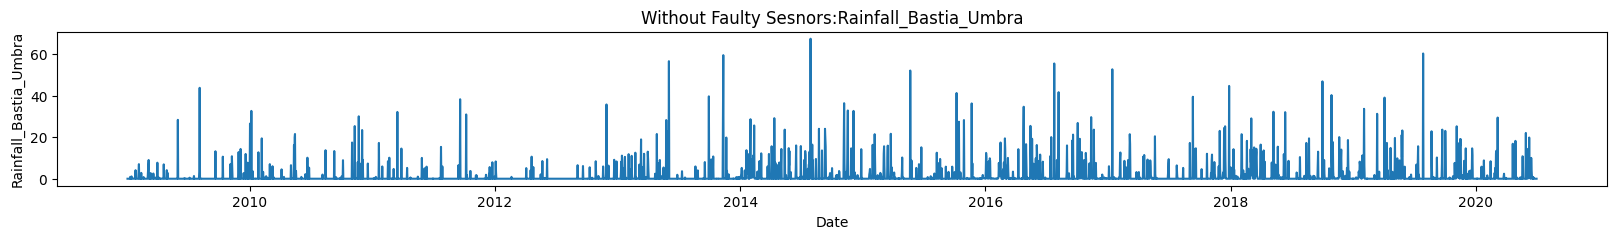

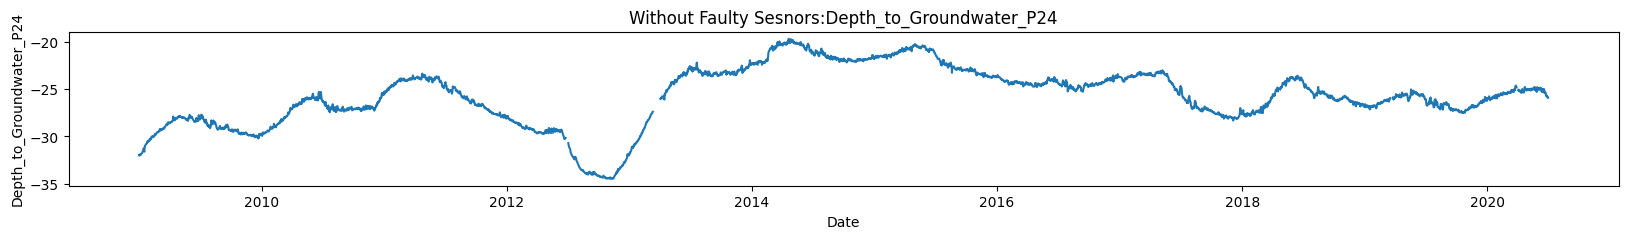

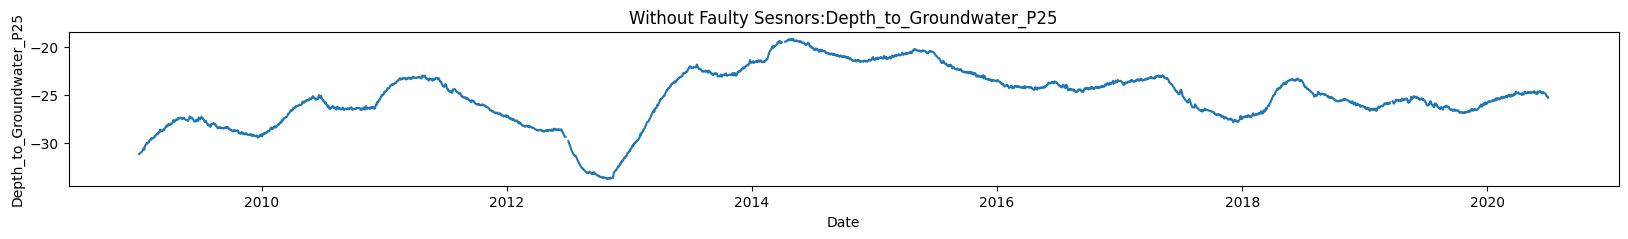

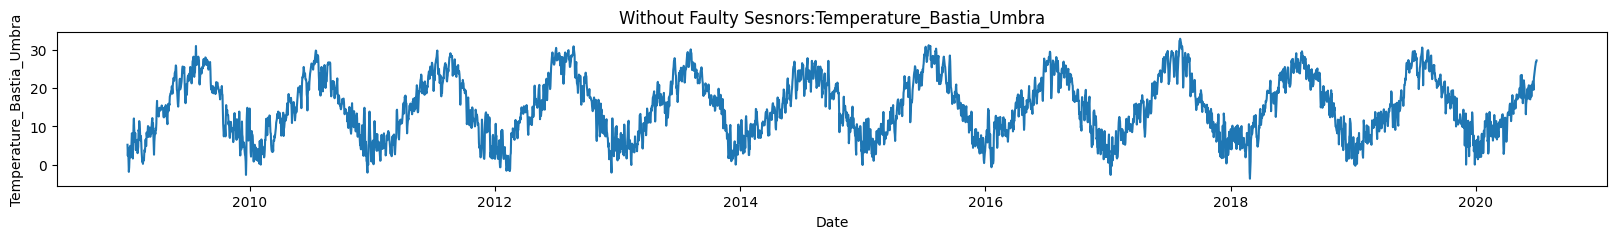

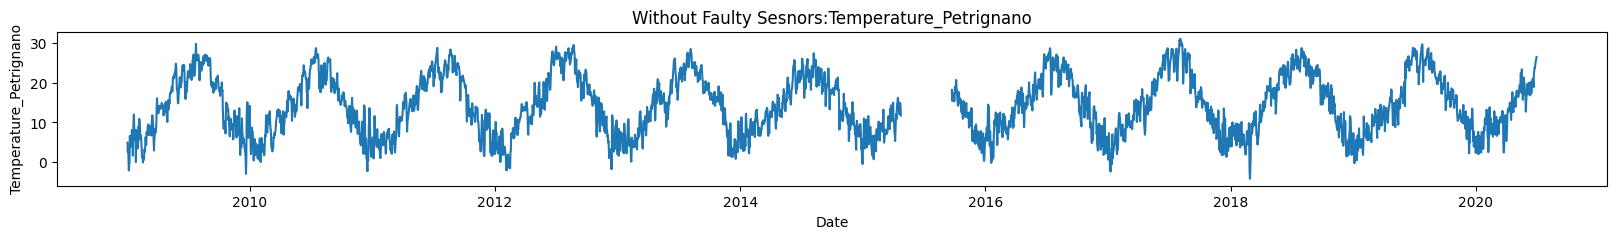

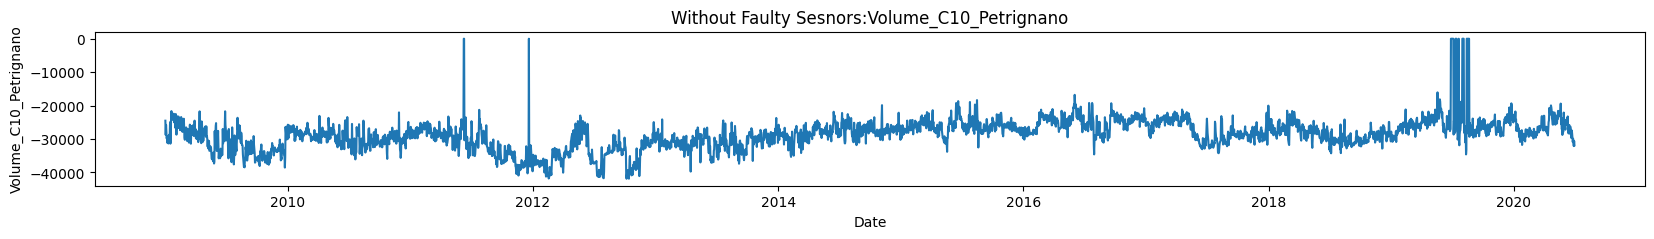

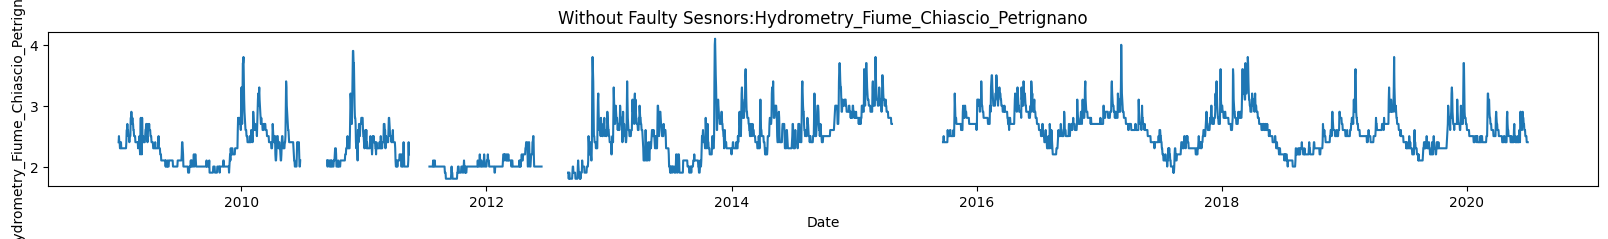

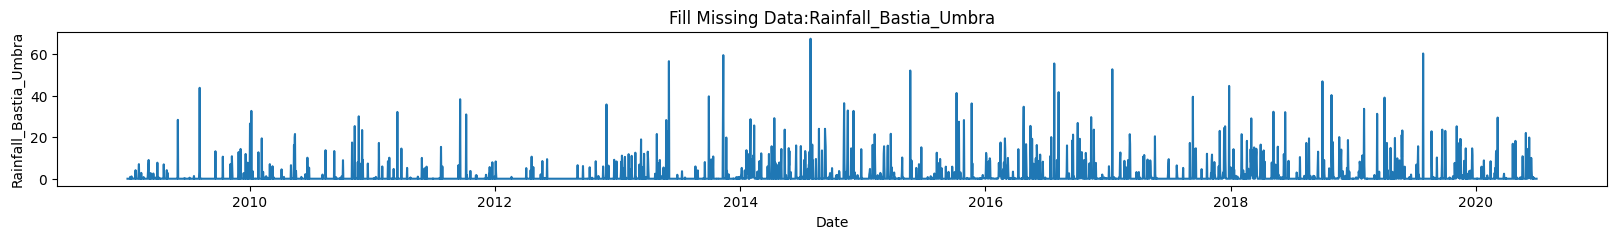

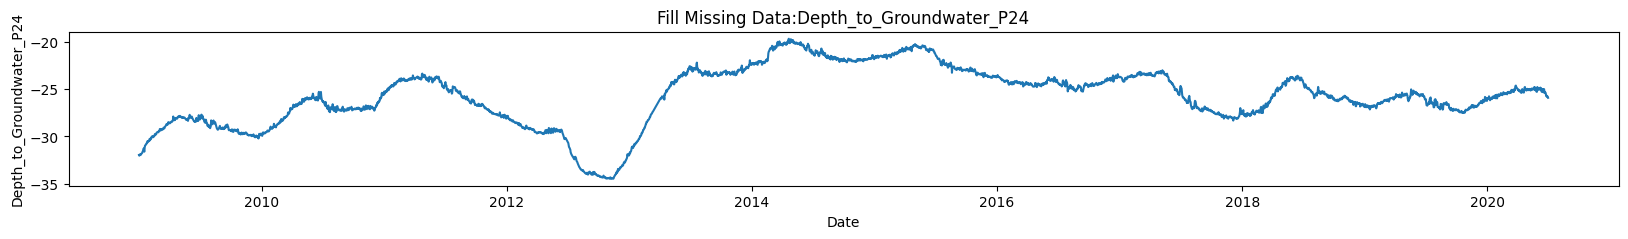

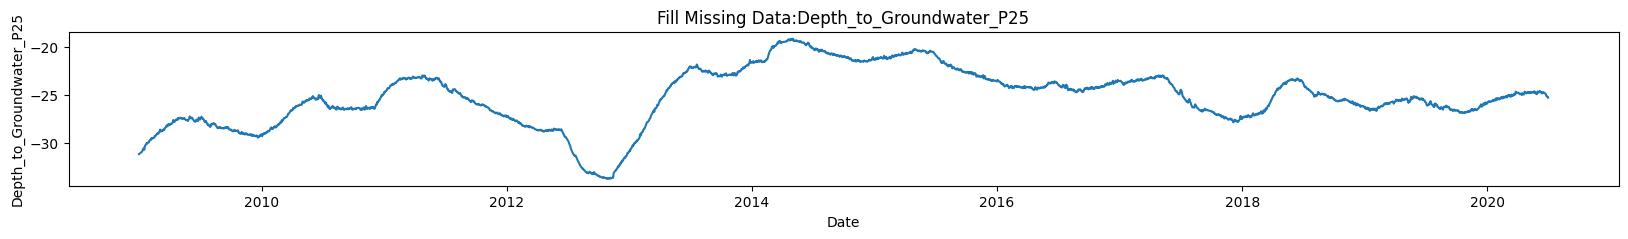

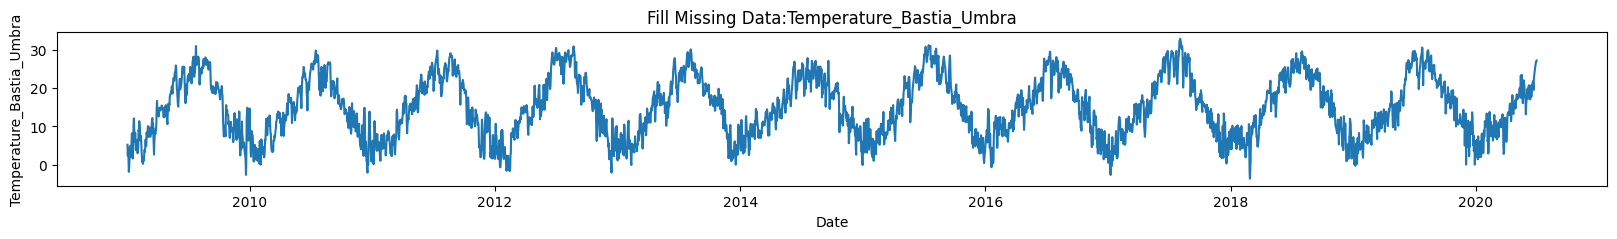

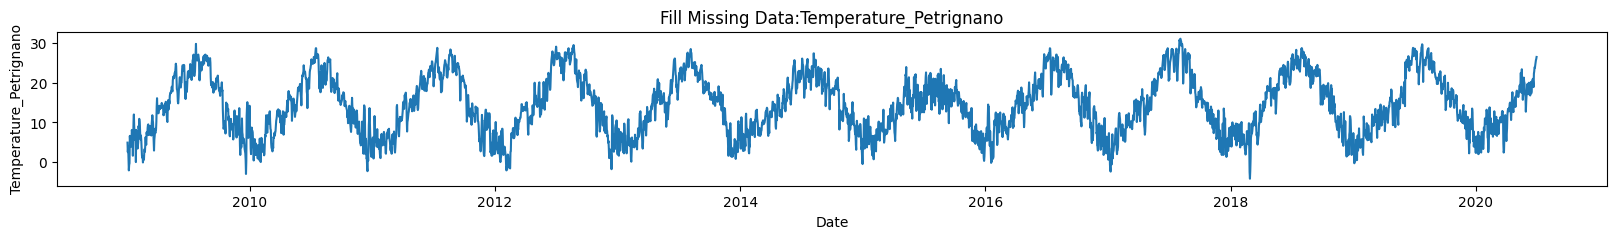

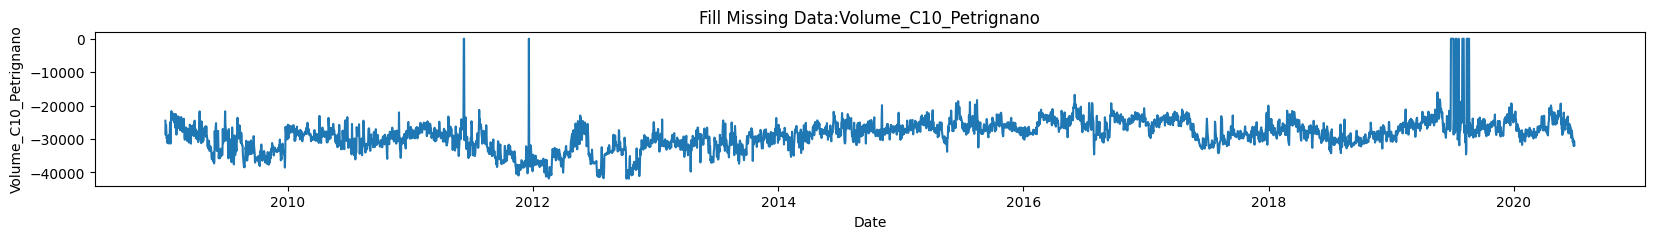

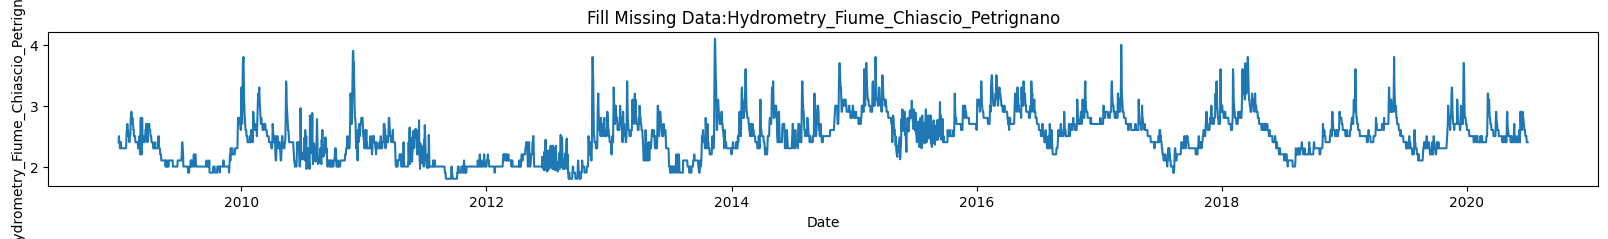

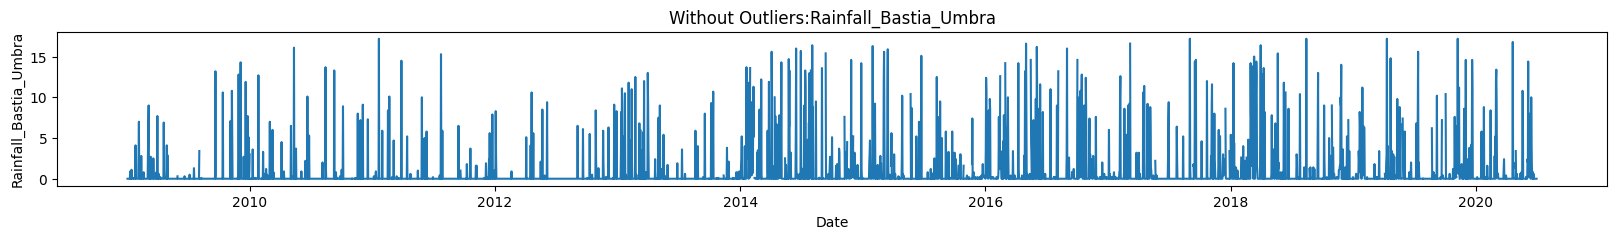

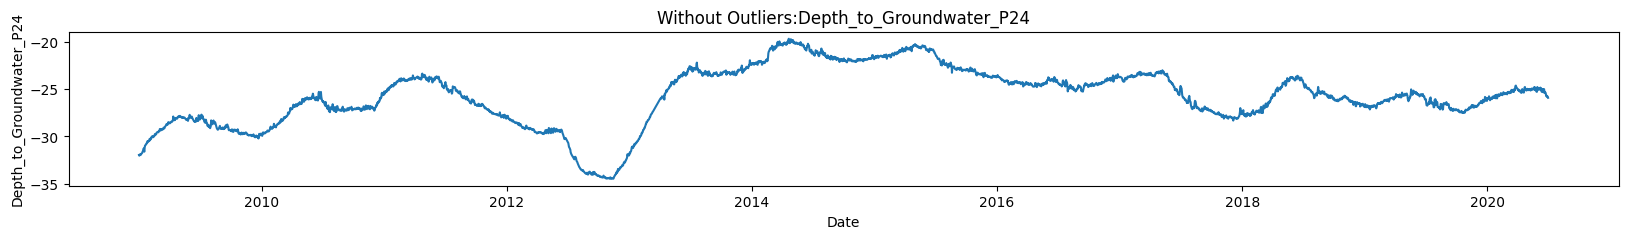

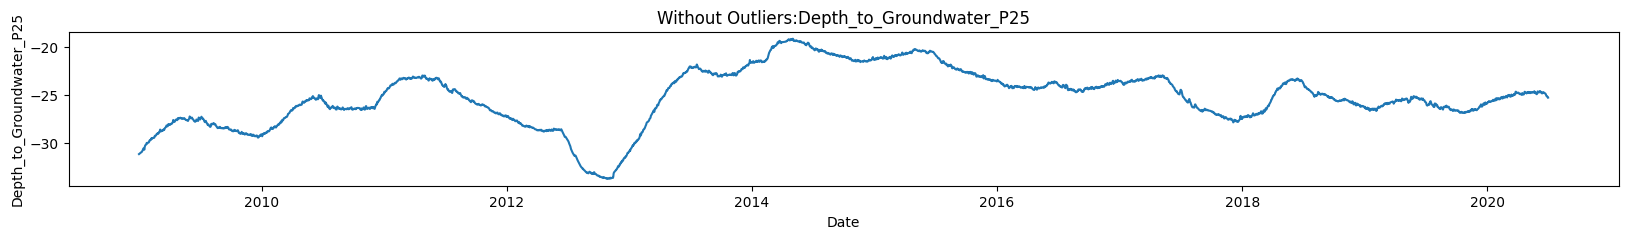

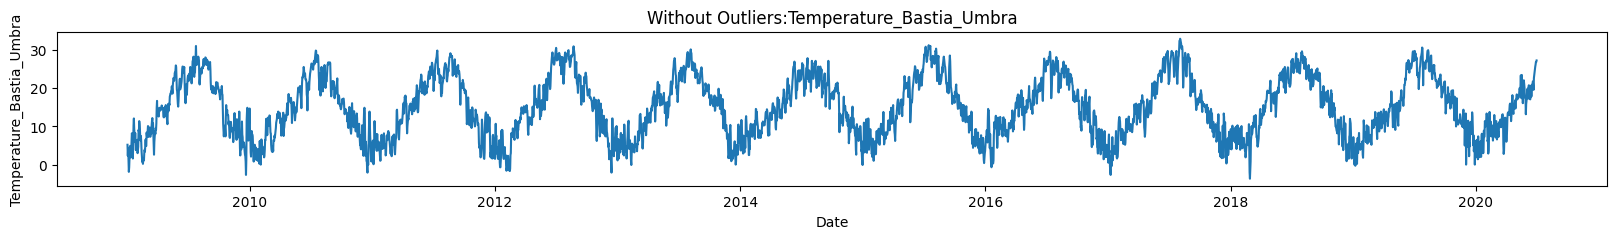

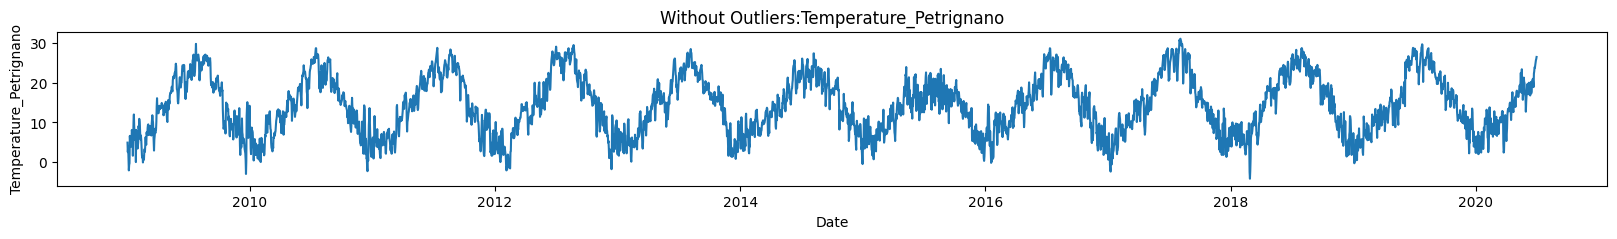

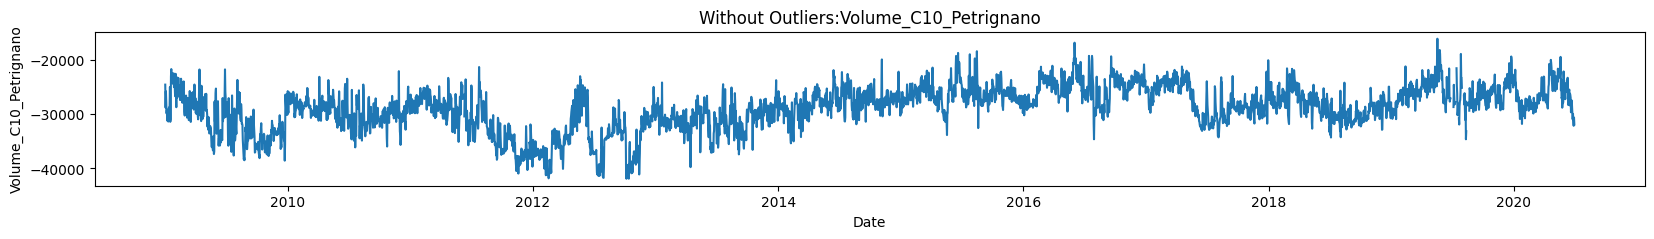

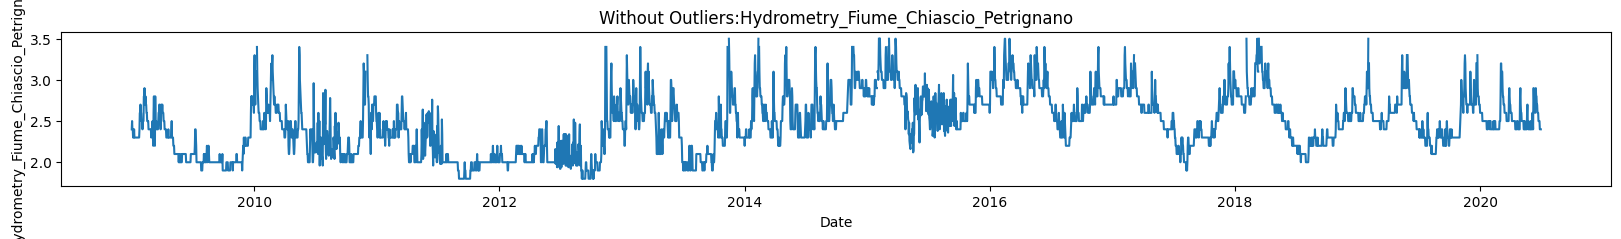

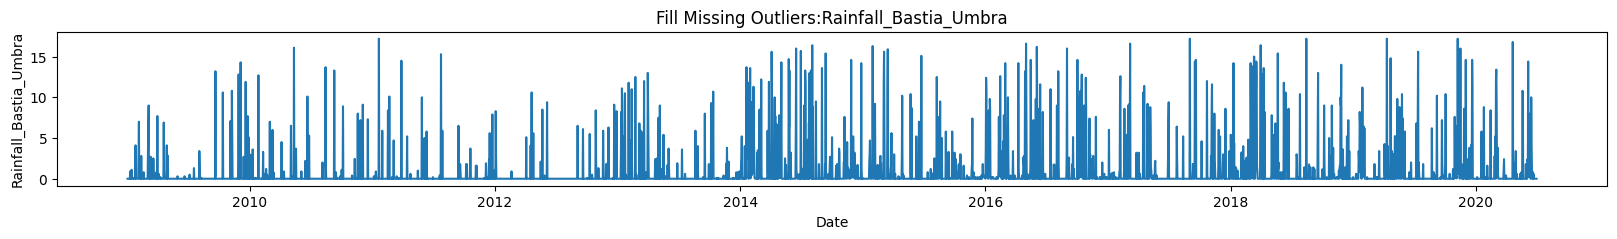

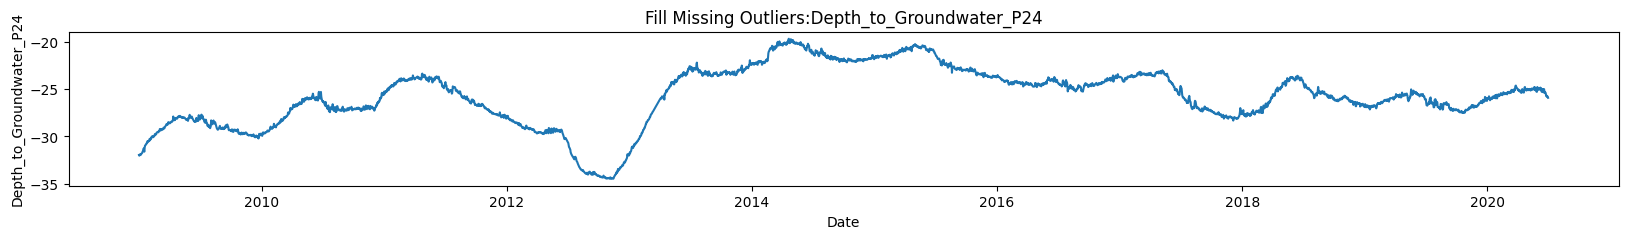

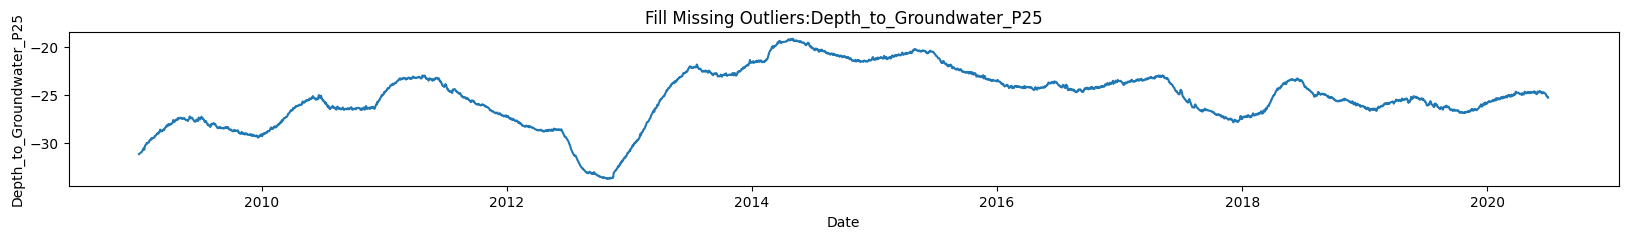

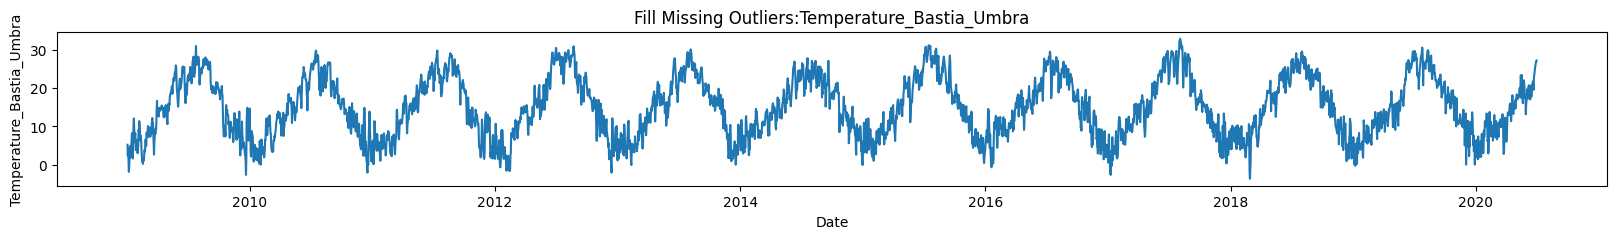

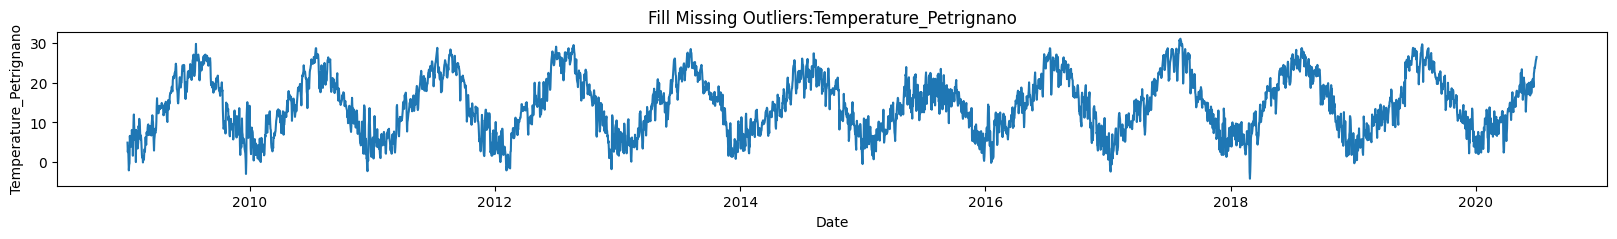

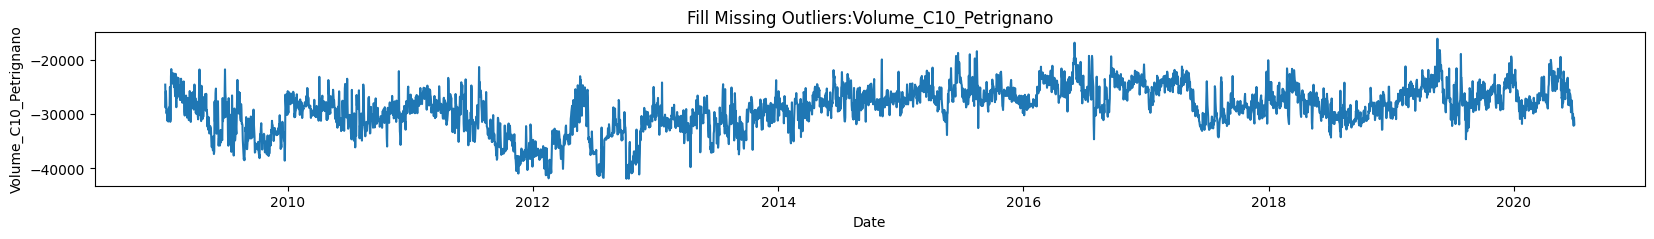

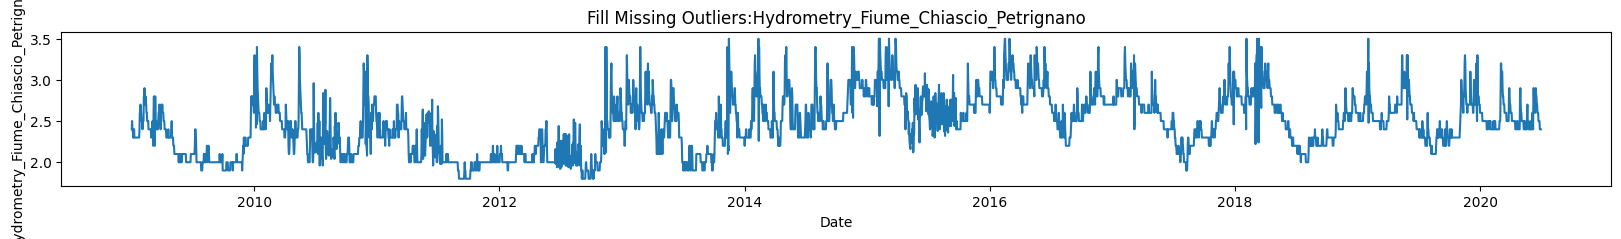

/tmp/ipykernel_841/1473483365.py:17: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[column].dtype == np.number:


In [30]:
df = pd.read_csv('Aquifer_Petrignano.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df = df[df['Date'] >= '2009-01-01']

show(df, "Original")

primitiveRemoveRepeatingValues(df, "Hydrometry_Fiume_Chiascio_Petrignano")
primitiveRemoveRepeatingValues(df, "Temperature_Petrignano")

show(df, "Without Faulty Sesnors")

df = fillMissing(df)

show(df, "Fill Missing Data")

outliersThreshold = 3

numeric_columns = df.select_dtypes(include=np.number).columns
for column in numeric_columns:
    z_scores = zscore(df[column])
    threshold = 3
    df[column] = df[column].where(z_scores < threshold, np.nan)

show(df, "Without Outliers")

df = fillMissing(df)

show(df, "Fill Missing Outliers")
df.set_index('Date', inplace=True)

df = normalize(df)

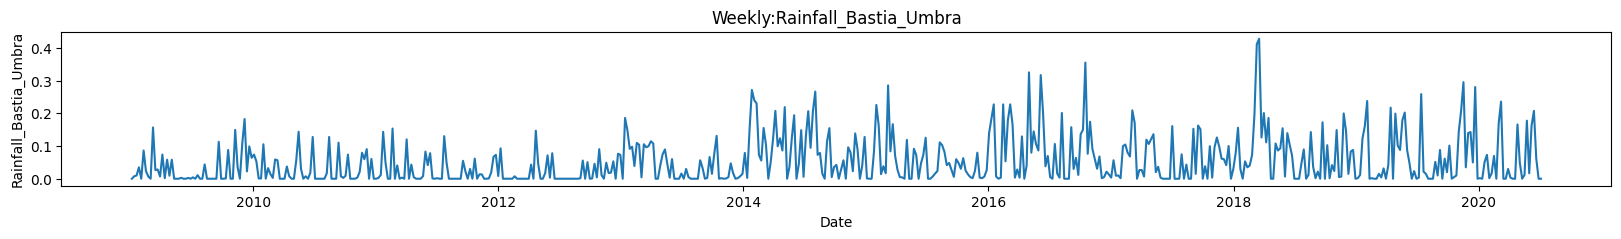

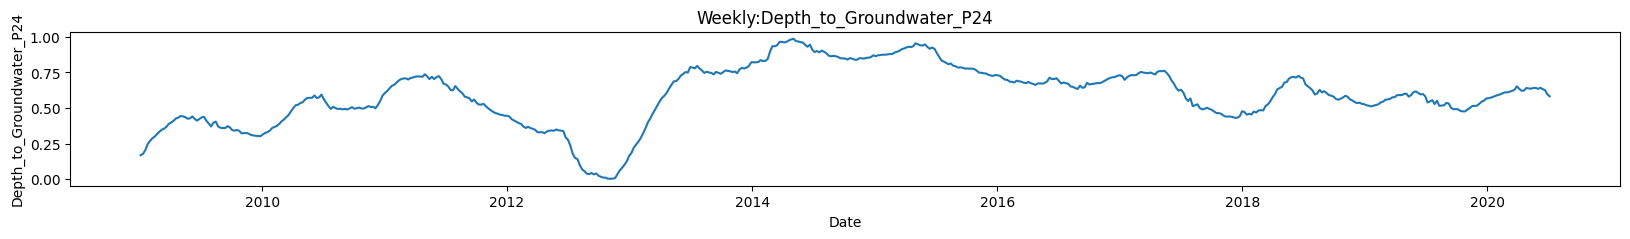

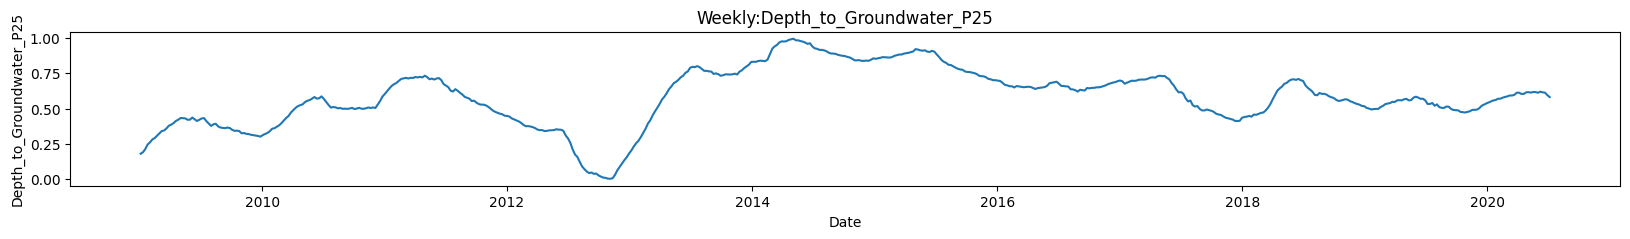

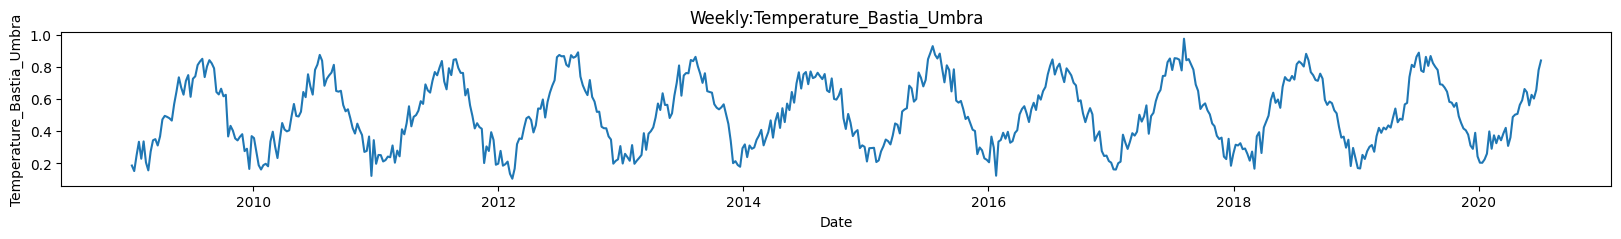

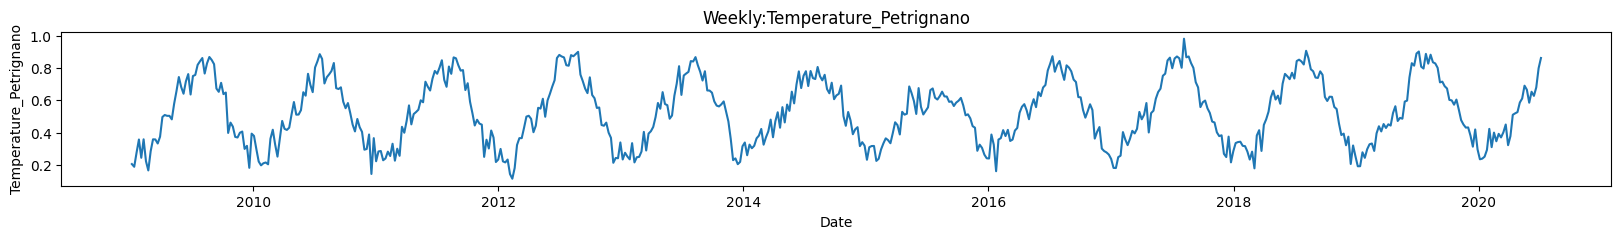

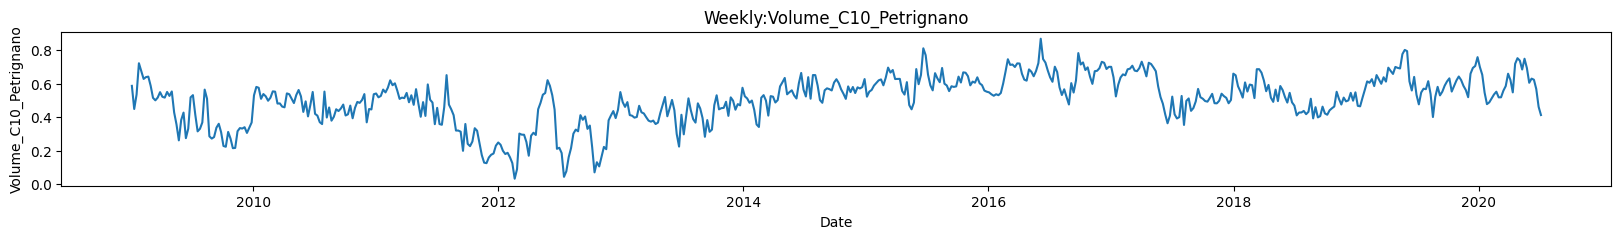

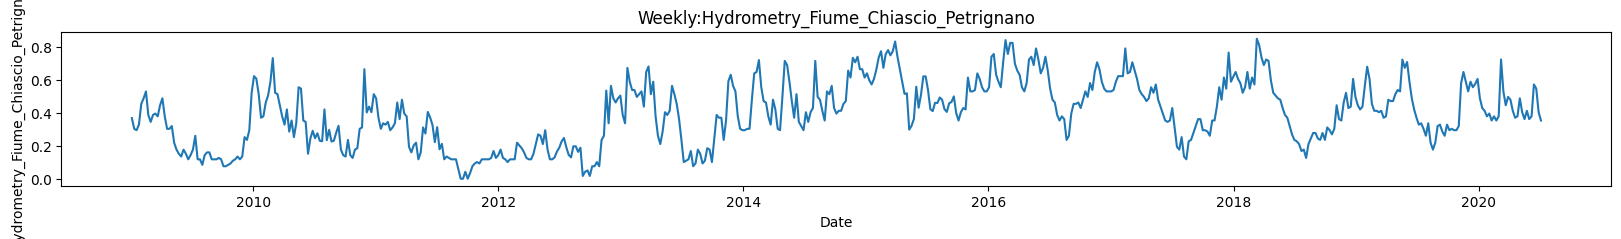

In [31]:
df_weekly = df.resample('W').mean()
show(df_weekly, "Weekly", True)

In [32]:
weeklyDepth = df_weekly["Depth_to_Groundwater_P25"].values.tolist()

train = weeklyDepth[:-40 * 4]
val = weeklyDepth[-40 * 4:-20 * 4]
test = weeklyDepth[-20 * 4:]

In [33]:
weeksToPredictFrom = 20

def divideXY(weeklyDepth):
    global weeksToPredictFrom
    x = []
    y = []
    for i in range(len(weeklyDepth) - weeksToPredictFrom - 4):
        x.append(weeklyDepth[i:i+weeksToPredictFrom])
        y.append(weeklyDepth[i+weeksToPredictFrom: i + weeksToPredictFrom + 4])
    print(tf.convert_to_tensor(x).shape)
    print(tf.convert_to_tensor(y).shape)
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)

In [34]:
train_x, train_y = divideXY(train)
test_x, test_y = divideXY(test)
val_x, val_y = divideXY(val)

(417, 20)
(417, 4)
(56, 20)
(56, 4)
(56, 20)
(56, 4)


2024-06-05 15:22:37.357380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 15:22:37.357472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 15:22:37.357506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 15:22:37.499832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 15:22:37.499856: I tensorflow/core/common_runtime/gpu/gpu

In [55]:
model = Sequential([
                    #LSTM(64, activation='relu', input_shape=(weeksToPredictFrom, 1), dropout=0.0, recurrent_dropout=0.0, return_sequences=True), 
                    LSTM(64, activation='relu', input_shape=(weeksToPredictFrom, 1), dropout=0.15, recurrent_dropout=0.0), 
                    #Dense(32, activation="leaky_relu"),
                    Dense(4)
                    ])

lr_schedule = ExponentialDecay(
    0.000045,
    decay_steps=100,
    decay_rate=0.965,
    staircase=True)

early_stopping = EarlyStopping(patience=100, restore_best_weights=True, verbose=1)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mae'])

model.fit(
    train_x, train_y,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    validation_data=(val_x, val_y),
    verbose=1
)

loss, mae = model.evaluate(test_x, test_y)
print("Loss:", loss, "MAE:", mae)


Epoch 1/1000
14/14 [==============================] - 2s 67ms/step - loss: 0.3927 - mae: 0.5825 - val_loss: 0.2930 - val_mae: 0.5302
Epoch 2/1000
14/14 [==============================] - 1s 53ms/step - loss: 0.3846 - mae: 0.5763 - val_loss: 0.2872 - val_mae: 0.5249
Epoch 3/1000
14/14 [==============================] - 1s 56ms/step - loss: 0.3772 - mae: 0.5705 - val_loss: 0.2812 - val_mae: 0.5193
Epoch 4/1000
14/14 [==============================] - 1s 56ms/step - loss: 0.3688 - mae: 0.5639 - val_loss: 0.2752 - val_mae: 0.5137
Epoch 5/1000
14/14 [==============================] - 1s 53ms/step - loss: 0.3614 - mae: 0.5579 - val_loss: 0.2692 - val_mae: 0.5080
Epoch 6/1000
14/14 [==============================] - 1s 56ms/step - loss: 0.3537 - mae: 0.5518 - val_loss: 0.2633 - val_mae: 0.5023
Epoch 7/1000
14/14 [==============================] - 1s 56ms/step - loss: 0.3459 - mae: 0.5452 - val_loss: 0.2568 - val_mae: 0.4958
Epoch 8/1000
14/14 [==============================] - 1s 53ms/step - 

1/1 [==============================] - 0s 39ms/step


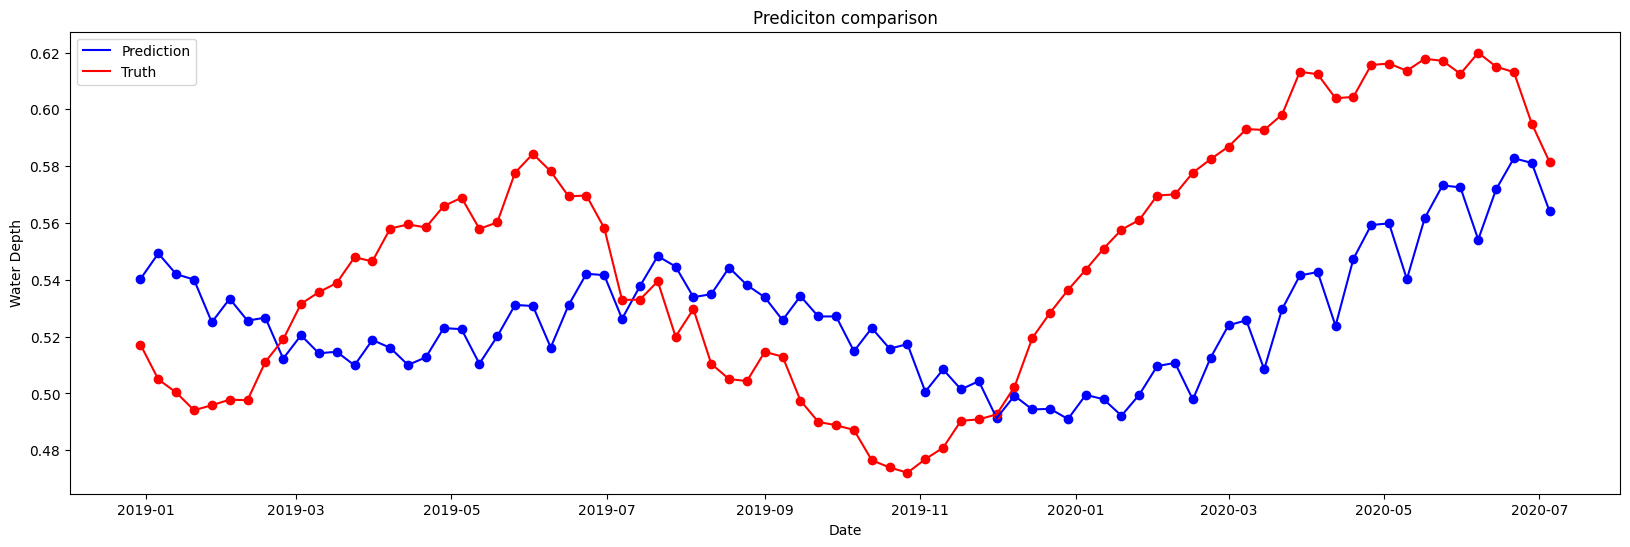

In [57]:
time = -20

x = df_weekly[time * 4:].index
pred_y_x = [weeklyDepth[(time + i) * 4 - weeksToPredictFrom:(time + i) * 4] for i in range(len(x)//4)]
pred_y = model.predict(pred_y_x)
pred_y = pred_y.reshape(-1, 1)

plt.figure(figsize=(20, 6))
plt.title("Prediciton comparison")
plt.xlabel('Date')
plt.ylabel("Water Depth")

plt.plot(x, pred_y, color='blue', label = "Prediction")
plt.scatter(x, pred_y, color='blue', label=None)

plt.plot(x, weeklyDepth[time * 4:], color='red', label='Truth')
plt.scatter(x, weeklyDepth[time * 4:], color='red', label=None)
plt.legend()
plt.show()